In [52]:
import re, string, os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer


CSV_PATH = "Data_Ulasan NETFLIX.csv"
OUTPUT_FILE = "Hasil_Preprocessing_Ulasan_NETFLIX.xlsx"
TARGET_COL = "Ulasan Teks"

PRINT_TOP = True
TOP_N = 10

# ===================== KAMUS & DAFTAR =====================
STOPWORDS = {
    'yang','dan','di','ke','dari','untuk','dengan','pada','ini','itu','karena','dalam','trus','saja','jaring','duit',
    'atau','ada','jadi','saya','kami','kita','kamu','dia','mereka','akan','bisa','tidak','cuma','bener','sering','suruh',
    'ya','nah','kok','kan','lah','dong','deh','tapi','lagi','udah','udahh','udahhh','gajelas','apa','aku','mana','mantap',
    'sih','banget','bgt','bangettt','aja','ajaah','ajaaja','kayak','kayaknya','gitu','mau','ngga','gajelas','doang',
    'nih','tuh','loh','lho','yah','plis','please','tolong','dah','nggak','jang','bul','pas','tetep','deng','nya','mulu'
}

BLACKLIST = {
    "xxx","test","lorem","ipsum","dummy",
    # buang entitas/objek jika ingin fokus pada isi keluhan
    "netflix","akun","account","email","password","pw","id","order","pesanan",
    "aplikasi","aplikasinya","app","appnya","versi","update","otp","kode","kodeotp",
}

REMOVE_OBJECT_TERMS = True
OBJECT_TERMS = {
    "netflix","akun","email","password","otp","subs","langganan","paket","billing",
    "tv","android","ios","premium","basic","standard","hd","uhd","4k"
}

ABBREV_SLANG_MAP = {
    "gk":"tidak","ga":"tidak","gak":"tidak","enggak":"tidak","tdk":"tidak",
    "yg":"yang","dgn":"dengan","sm":"sama","dr":"dari","tp":"tapi","tpi":"tapi",
    "krn":"karena","kalo":"kalau","klo":"kalau","kl":"kalau","dlm":"dalam",
    "utk":"untuk","biar":"agar","bikin":"membuat",
    "udh":"sudah","sdh":"sudah","udah":"sudah","blm":"belum","belom":"belum",
    "msh":"masih","bkn":"bukan","dpt":"dapat","hrs":"harus","bs":"bisa","lg":"lagi",
    "pls":"tolong","plis":"tolong","mksh":"terima kasih","makasih":"terima kasih",
    "kmrn":"kemarin","skrg":"sekarang",
    "subs":"langganan","sub":"langganan","acc":"akun","verif":"verifikasi","notif":"notifikasi",
}

TYPO_MAP = {
    "ganguan":"gangguan","gangu":"ganggu","perbiki":"perbaiki","aplikas":"aplikasi",
    "susahh":"susah","lemottt":"lemot","lambatt":"lambat","layaranya":"layarnya","bayarr":"bayar"
}

NO_VOWEL_EXCEPTIONS = {"tv","hd","uhd","bca","vpn","apk","apkmod","otp"}

# ===================== REGEX UTIL =====================
RE_URL   = re.compile(r"(https?://\S+|www\.\S+)", re.I)
RE_EMAIL = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", re.I)
RE_PHONE = re.compile(r"\b(\+?\d[\d\-\s]{6,}\d)\b")
RE_HASHTAG = re.compile(r"(#\w+)")
RE_MENTION = re.compile(r"(@\w+)")
RE_NONASCII = re.compile(r"[^\x00-\x7F]+")
RE_PUNCT = re.compile(rf"[{re.escape(string.punctuation)}]")
RE_MULTI_SPACE = re.compile(r"\s+")
RE_TOKEN = re.compile(r"[a-z0-9_]+", re.I)

# ===================== HELPER PREPROCESS =====================
def has_vowel(token: str) -> bool:
    return any(v in token for v in "aiueo")

# 1) CASEFOLDING
def casefolding(text: str) -> str:
    text = str(text).lower()
    text = RE_NONASCII.sub(" ", text)   # buang emoji/non-ASCII
    text = RE_URL.sub(" ", text)        # buang URL
    text = RE_EMAIL.sub(" ", text)      # buang email
    text = RE_PHONE.sub(" ", text)      # buang nomor telepon
    text = RE_HASHTAG.sub(" ", text)    # buang hashtag
    text = RE_MENTION.sub(" ", text)    # buang mention
    text = RE_PUNCT.sub(" ", text)      # buang tanda baca
    text = RE_MULTI_SPACE.sub(" ", text).strip()
    return text

# 2) TOKENIZING
def tokenizing(text: str):
    return RE_TOKEN.findall(text)

# normalisasi token (slang/typo & huruf berulang)
def normalize_token(token: str) -> str:
    token = re.sub(r"(.)\1{2,}", r"\1", token)  # aaa -> a
    token = re.sub(r"(.)\1$", r"\1", token)     # akhiran dobel -> 1
    token = ABBREV_SLANG_MAP.get(token, token)  # slang/singkatan
    token = TYPO_MAP.get(token, token)          # typo map
    return token

# 3) STEMMING
def simple_stem(word: str) -> str:
    suffixes = ['kah','nya','tah','pun','ku','mu','kan','an','lah']
    for suf in suffixes:
        if word.endswith(suf) and len(word) > len(suf) + 2:
            return word[:-len(suf)]
    return word

def stemming(tokens):
    return [simple_stem(normalize_token(t)) for t in tokens]

# 4) FILTERING
def filtering(tokens):
    filtered = []
    for token in tokens:
        if len(token) < 3:
            continue
        if token.isdigit():
            continue
        if token in STOPWORDS:
            continue
        if token in BLACKLIST:
            continue
        if REMOVE_OBJECT_TERMS and token in OBJECT_TERMS:
            continue
        if (not has_vowel(token)) and (token not in NO_VOWEL_EXCEPTIONS):
            continue
        filtered.append(token)
    return filtered

# Baca data
df_asli = pd.read_csv(CSV_PATH)

# pastikan kolom target
if TARGET_COL not in df_asli.columns:
    for c in ["Ulasan","ulasan","Review","review","Komentar","komentar","Text","text","Content","content","Body","body","Teks","teks"]:
        if c in df_asli.columns:
            TARGET_COL = c
            break
    else:
        TARGET_COL = df_asli.columns[0]

df_asli[TARGET_COL] = df_asli[TARGET_COL].astype(str).fillna("")

# ====== Save data ======
hasil = []
for teks in df_asli[TARGET_COL]:
    teks_case = casefolding(teks)
    tokens = tokenizing(teks_case)
    tokens_stem = stemming(tokens)
    tokens_filter = filtering(tokens_stem)
    teks_bersih = ' '.join(tokens_filter)
    hasil.append([teks, teks_case, tokens, tokens_stem, tokens_filter, teks_bersih])

df_hasil = pd.DataFrame(hasil, columns=[
    "Ulasan Asli", "Casefolding", "Tokenizing", "Stemming", "Filtering", "Ulasan_Bersih"
])

df_hasil.to_excel(OUTPUT_FILE, index=False)
print(f"✅ File preprocessing berhasil dibuat: {OUTPUT_FILE}")
print(df_hasil.head(10))
print(f"(Info) Kolom teks yang dipakai: '{TARGET_COL}'")


✅ File preprocessing berhasil dibuat: Hasil_Preprocessing_Ulasan_NETFLIX.xlsx
                                         Ulasan Asli                                        Casefolding  \
0  Halo selamat malam admin, untuk anime ONE PIEC...  halo selamat malam admin untuk anime one piece...   
1  rating ga seberapa loginnya susah minta ampun ...  rating ga seberapa loginnya susah minta ampun ...   
2           Payah gak bisa dibuka percuma di donload           payah gak bisa dibuka percuma di donload   
3                                               good                                               good   
4                      kualitas flimnya bagus sekali                      kualitas flimnya bagus sekali   
5                                     Gpp bagus aja😊                                      gpp bagus aja   
6  sudah berhenti berlangganan masih aja saldo sy...  sudah berhenti berlangganan masih aja saldo sy...   
7  Assalamu'alaikum. Kpd yg terhormat aplikasi ne...  assalamu ala


=== TOP 10 UNIGRAM ===
Kata/Frasa  Frekuensi
     sudah        306
      film        187
    nonton        149
     bayar        132
   padahal        128
     login        117
     masuk        113
     bagus        105
    kenapa         89
    daftar         78

=== TOP 10 BIGRAM ===
      Kata/Frasa  Frekuensi
     sudah bayar         52
   padahal sudah         39
       tiba tiba         21
   sudah langgan         18
sudah berlanggan         15
     nonton film         14
    terima kasih         14
     buat nonton         11
     harus bayar         11
    sangat bagus         11

=== TOP 10 TRIGRAM ===
           Kata/Frasa  Frekuensi
  padahal sudah bayar          9
  login padahal sudah          6
   daftar harus bayar          5
  film kurang lengkap          5
     buat nonton film          4
  sudah bayar langgan          4
   sudah daftar sudah          4
      bagus film film          3
dapat terhubung terus          3
 nonton loading terus          3


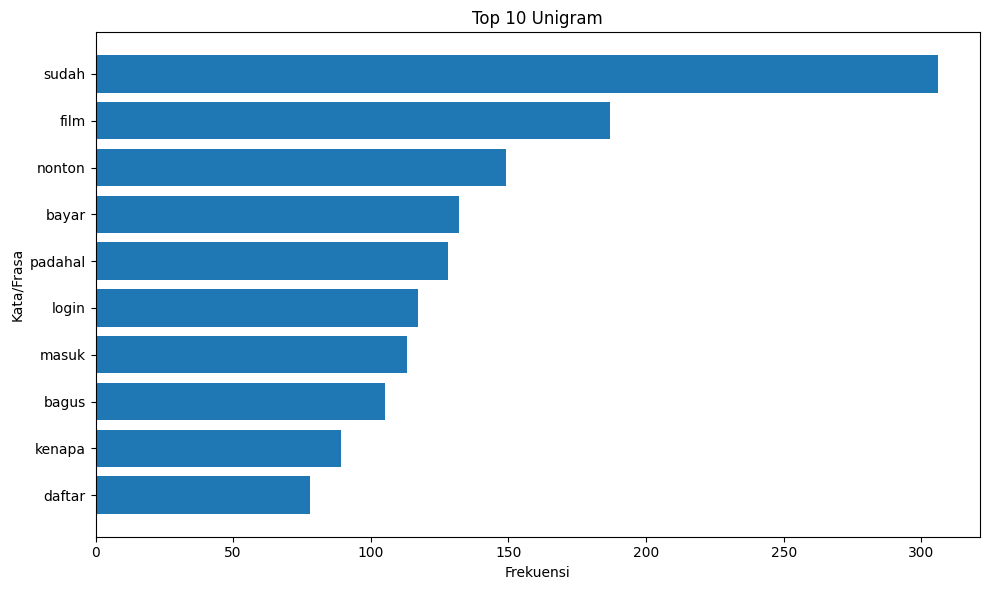

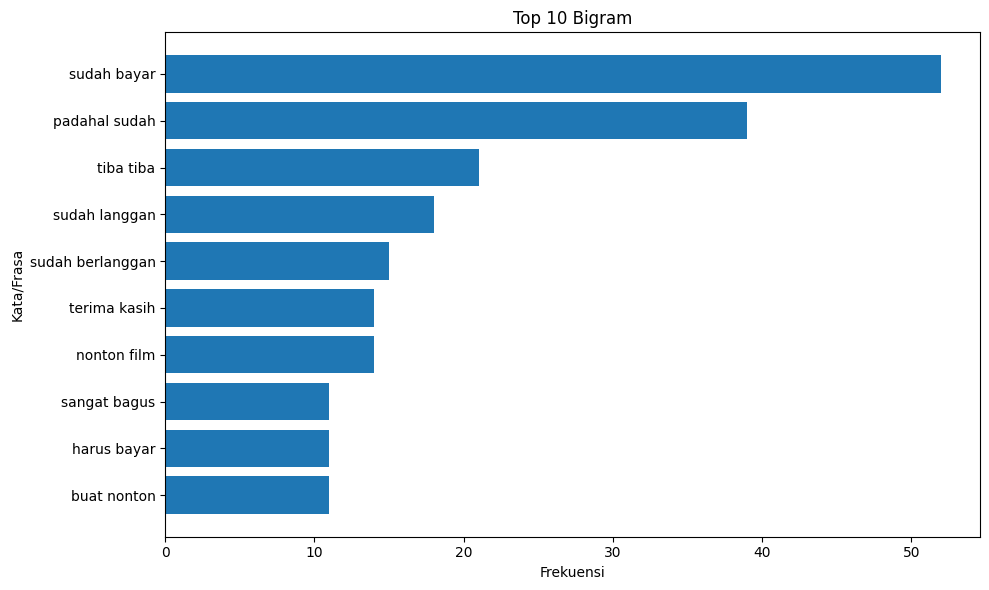

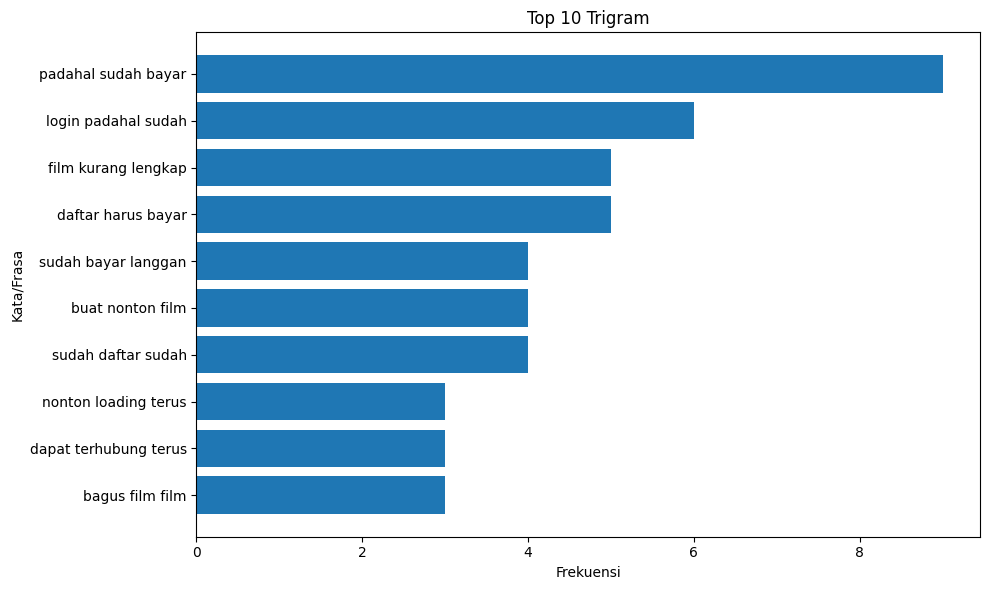

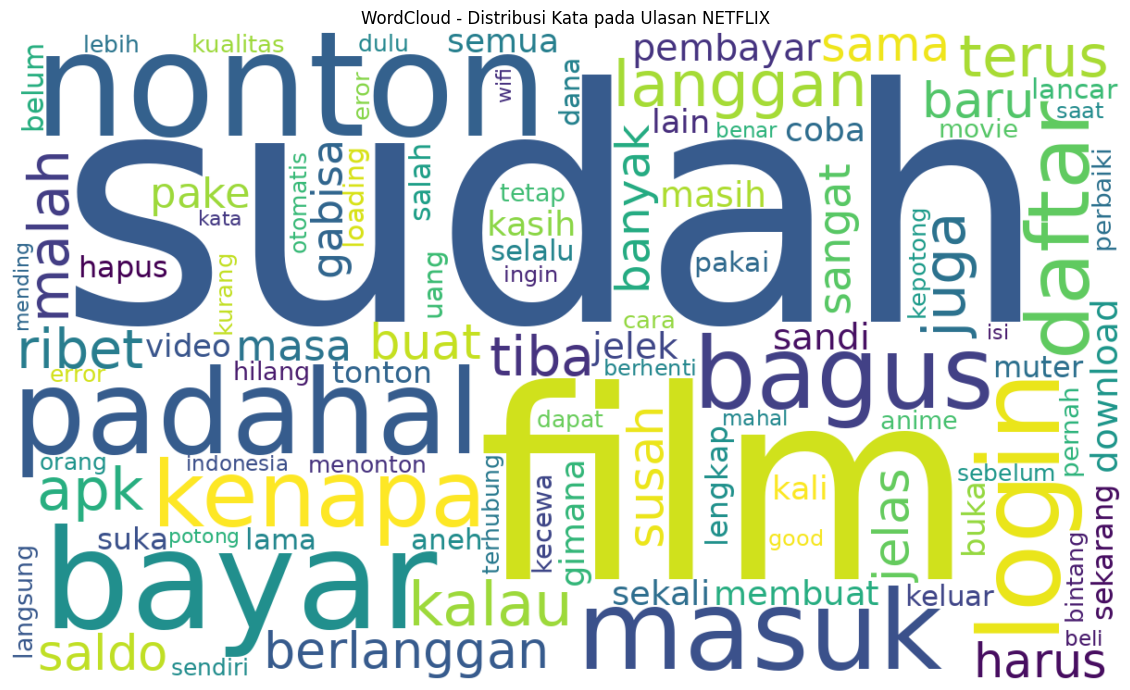

In [53]:
#VISUALISASI

# 1) WordCloud dari Ulasan_Bersih
def show_wordcloud_from_df(df_preproc):
    corpus = " ".join(df_preproc["Ulasan_Bersih"].dropna().astype(str))
    if not corpus.strip():
        print("Corpus kosong — WordCloud dilewati.")
        return
    try:
        from wordcloud import WordCloud
        from matplotlib import font_manager
        font_path = None
        for name in ["DejaVu Sans","Arial","Liberation Sans","Nimbus Sans"]:
            try:
                fp = font_manager.findfont(name, fallback_to_default=False)
                if os.path.exists(fp):
                    font_path = fp
                    break
            except Exception:
                continue

        wc = WordCloud(
            width=1200, height=700,
            background_color="white",
            collocations=False, max_words=100,
            font_path=font_path
        ).generate(corpus)
        plt.figure(figsize=(12,7))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title("WordCloud - Distribusi Kata pada Ulasan NETFLIX")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("⚠️ WordCloud tidak dapat ditampilkan. Pesan:", e)
        print("   Solusi: install 'wordcloud' & pastikan ada font TTF. Atau set font_path manual.")

# 2) Top N-Gram (bar chart horizontal, tampil di layar)
def get_top_ngrams(corpus, n=10, ngram_range=(1,1)):
    vec = CountVectorizer(ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    freqs = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    top = sorted(freqs, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(top, columns=["Kata/Frasa","Frekuensi"])

def plot_barh_terminal(df_top, title):
    if df_top.empty:
        print(f"[{title}] Data kosong — grafik dilewati.")
        return
    df_top = df_top.copy()
    df_top["Kata/Frasa"] = df_top["Kata/Frasa"].astype(str)
    df_top["Frekuensi"]  = pd.to_numeric(df_top["Frekuensi"], errors="coerce").fillna(0)
    df_top = df_top.sort_values("Frekuensi", ascending=True)
    plt.figure(figsize=(10,6))
    plt.barh(df_top["Kata/Frasa"], df_top["Frekuensi"])
    plt.xlabel("Frekuensi")
    plt.ylabel("Kata/Frasa")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Bangun korpus dari hasil preprocessing di memory (tanpa baca ulang Excel)
corpus = df_hasil["Ulasan_Bersih"].fillna("").astype(str).tolist()

# Hitung top n-gram
top1 = get_top_ngrams(corpus, n=TOP_N, ngram_range=(1,1))
top2 = get_top_ngrams(corpus, n=TOP_N, ngram_range=(2,2))
top3 = get_top_ngrams(corpus, n=TOP_N, ngram_range=(3,3))

if PRINT_TOP:
    pd.set_option("display.width", 120)
    print(f"\n=== TOP {TOP_N} UNIGRAM ===")
    print(top1.to_string(index=False))
    print(f"\n=== TOP {TOP_N} BIGRAM ===")
    print(top2.to_string(index=False))
    print(f"\n=== TOP {TOP_N} TRIGRAM ===")
    print(top3.to_string(index=False))

# Tampilkan grafik (tanpa simpan file)
plot_barh_terminal(top1, f"Top {TOP_N} Unigram")
plot_barh_terminal(top2, f"Top {TOP_N} Bigram")
plot_barh_terminal(top3, f"Top {TOP_N} Trigram")

# Tampilkan WordCloud
show_wordcloud_from_df(df_hasil)